In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    # original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0520/weights_KD_segformer_0520_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.4
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.3958

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - loss: 0.3323
Average validation loss: 0.5731924772262573
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - loss: 0.3323 - val_loss: 0.5732
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 518ms/step - loss: 0.2543 - val_loss: 0.5732
Average validation loss: 0.4195905327796936
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 532ms/step - loss: 0.2543 - val_loss: 0.4964
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 506ms/step - loss: 0.2029 - val_loss: 0.4964
Average validation loss: 0.35713517665863037
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 515ms/step - loss: 0.2029 - val_loss: 0.4500
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segf

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 918ms/step - loss: 0.0371
Average validation loss: 0.22970083355903625
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 933ms/step - loss: 0.0371 - val_loss: 0.2297
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 962ms/step - loss: 0.0356 - val_loss: 0.2297
Average validation loss: 0.11585070565342903
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 977ms/step - loss: 0.0356 - val_loss: 0.1728
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 971ms/step - loss: 0.0332 - val_loss: 0.1728
Average validation loss: 0.37493086606264114
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 986ms/step - loss: 0.0332 - val_loss: 0.2402
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 881ms/step - loss: 0.0321 - val_loss: 0.2402
Average validation lo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 848ms/step - loss: 0.0217
Average validation loss: 0.25628483295440674
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 861ms/step - loss: 0.0217 - val_loss: 0.2563
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 872ms/step - loss: 0.0195 - val_loss: 0.2563
Average validation loss: 0.17143703500429788
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 888ms/step - loss: 0.0195 - val_loss: 0.2139
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 814ms/step - loss: 0.0175 - val_loss: 0.2139
Average validation loss: 0.14632602222263813
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 829ms/step - loss: 0.0175 - val_loss: 0.1913
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segforme

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 866ms/step - loss: 0.0097
Average validation loss: 0.0932160874363035
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 881ms/step - loss: 0.0097 - val_loss: 0.0932
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 844ms/step - loss: 0.0092 - val_loss: 0.0932
Average validation loss: 0.01791011984460056
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 858ms/step - loss: 0.0092 - val_loss: 0.0556
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 841ms/step - loss: 0.0088 - val_loss: 0.0556
Average validation loss: 0.11221186118200421
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 856ms/step - loss: 0.0088 - val_loss: 0.0744
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 862ms/step - loss: 0.0081 - val_loss: 0.0744
Averag

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 813ms/step - loss: 0.0146
Average validation loss: 0.03225944899022579
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 825ms/step - loss: 0.0146 - val_loss: 0.0323
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 805ms/step - loss: 0.0105 - val_loss: 0.0323
Average validation loss: 0.04120099311694503
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 818ms/step - loss: 0.0105 - val_loss: 0.0367
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 793ms/step - loss: 0.0088 - val_loss: 0.0367
Average validation loss: 0.008935948903672396
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 805ms/step - loss: 0.0088 - val_loss: 0.0275
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_25.pth'.
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 793ms/step - loss: 0.0076 - val_loss: 0.0275
Aver

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 792ms/step - loss: 0.0127
Average validation loss: 0.0068866068807741
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 803ms/step - loss: 0.0127 - val_loss: 0.0069
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 835ms/step - loss: 0.0096 - val_loss: 0.0069
Average validation loss: 0.006114676032060136
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 846ms/step - loss: 0.0096 - val_loss: 0.0065
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 809ms/step - loss: 0.0078 - val_loss: 0.0065
Average validation loss: 0.008667636468696097
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 821ms/step - loss: 0.0078 - val_loss: 0.0072
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 78s 795ms/step - loss: 0.0068 - val_loss: 0.0072
Aver

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 803ms/step - loss: 0.0104
Average validation loss: 0.01691687158017885
40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 817ms/step - loss: 0.0104 - val_loss: 0.0169
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 67s 857ms/step - loss: 0.0077 - val_loss: 0.0169
Average validation loss: 0.022824582853354515
40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 871ms/step - loss: 0.0077 - val_loss: 0.0199
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 100s 816ms/step - loss: 0.0064 - val_loss: 0.0199
Average validation loss: 0.01253004977479577
40/40 ━━━━━━━━━━━━━━━━━━━━ 101s 830ms/step - loss: 0.0064 - val_loss: 0.0174
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_50.pth'.
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 133s 801ms/step - loss: 0.0056 - val_loss: 0.0174
A

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 793ms/step - loss: 0.0065
Average validation loss: 0.006067622322007082
48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 807ms/step - loss: 0.0065 - val_loss: 0.0061
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 805ms/step - loss: 0.0048 - val_loss: 0.0061
Average validation loss: 0.007392101363317731
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 819ms/step - loss: 0.0048 - val_loss: 0.0067
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 119s 855ms/step - loss: 0.0040 - val_loss: 0.0067
Average validation loss: 0.004510612636901594
48/48 ━━━━━━━━━━━━━━━━━━━━ 120s 869ms/step - loss: 0.0040 - val_loss: 0.0060
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_60.pth'.
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 161s 848ms/step - loss: 0.0036 - val_loss: 0.0060

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 804ms/step - loss: 0.0056
Average validation loss: 0.007681047111483557
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 817ms/step - loss: 0.0056 - val_loss: 0.0077
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 90s 794ms/step - loss: 0.0043 - val_loss: 0.0077
Average validation loss: 0.0077114454304267254
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 808ms/step - loss: 0.0043 - val_loss: 0.0077
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 136s 798ms/step - loss: 0.0036 - val_loss: 0.0077
Average validation loss: 0.004468226015368211
56/56 ━━━━━━━━━━━━━━━━━━━━ 137s 812ms/step - loss: 0.0036 - val_loss: 0.0066
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_70.pth'.
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 181s 794ms/step - loss: 0.0032 - val_loss: 0.006

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 807ms/step - loss: 0.0037
Average validation loss: 0.011328685744956601
64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 820ms/step - loss: 0.0037 - val_loss: 0.0113
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 104s 806ms/step - loss: 0.0030 - val_loss: 0.0113
Average validation loss: 0.006789357415982522
64/64 ━━━━━━━━━━━━━━━━━━━━ 105s 821ms/step - loss: 0.0030 - val_loss: 0.0091
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 157s 808ms/step - loss: 0.0026 - val_loss: 0.0091
Average validation loss: 0.00609945736505324
64/64 ━━━━━━━━━━━━━━━━━━━━ 158s 821ms/step - loss: 0.0026 - val_loss: 0.0081
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_se

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 60s 835ms/step - loss: 0.0028
Average validation loss: 0.27742839894360966
72/72 ━━━━━━━━━━━━━━━━━━━━ 61s 849ms/step - loss: 0.0028 - val_loss: 0.2774
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 121s 828ms/step - loss: 0.0023 - val_loss: 0.2774
Average validation loss: 0.016752537787801378
72/72 ━━━━━━━━━━━━━━━━━━━━ 122s 842ms/step - loss: 0.0023 - val_loss: 0.1471
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 180s 809ms/step - loss: 0.0020 - val_loss: 0.1471
Average validation loss: 0.01340821995108854
72/72 ━━━━━━━━━━━━━━━━━━━━ 181s 822ms/step - loss: 0.0020 - val_loss: 0.1025
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_seg

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 69s 858ms/step - loss: 0.0027
Average validation loss: 0.004170240375970025
80/80 ━━━━━━━━━━━━━━━━━━━━ 70s 871ms/step - loss: 0.0027 - val_loss: 0.0042
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 134s 800ms/step - loss: 0.0023 - val_loss: 0.0042
Average validation loss: 0.0032211048834142274
80/80 ━━━━━━━━━━━━━━━━━━━━ 135s 813ms/step - loss: 0.0023 - val_loss: 0.0037
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 199s 799ms/step - loss: 0.0021 - val_loss: 0.0037
Average validation loss: 0.003309858417196665
80/80 ━━━━━━━━━━━━━━━━━━━━ 200s 812ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 264s 803ms/step - loss: 0.0019 - val_loss: 0

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 89s 928ms/step - loss: 0.0040
Average validation loss: 0.007474175833825332
96/96 ━━━━━━━━━━━━━━━━━━━━ 90s 942ms/step - loss: 0.0040 - val_loss: 0.0075
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 169s 817ms/step - loss: 0.0030 - val_loss: 0.0075
Average validation loss: 0.008971926474866146
96/96 ━━━━━━━━━━━━━━━━━━━━ 170s 831ms/step - loss: 0.0030 - val_loss: 0.0082
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 249s 823ms/step - loss: 0.0026 - val_loss: 0.0082
Average validation loss: 0.013614946981154693
96/96 ━━━━━━━━━━━━━━━━━━━━ 250s 837ms/step - loss: 0.0026 - val_loss: 0.0100
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 327s 804ms/step - loss: 0.0023 - val_loss: 0.0100
Average validation loss: 0.01849456450145226
96/96 ━━━━━━━━━━━━━━━━━━━━ 329s 817ms/step - loss: 0.0023 - val_loss: 0.0121
Epoch 5/10
96/96 ━━━━━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 795ms/step - loss: 0.0060
Average validation loss: 0.0057006845842503635
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 808ms/step - loss: 0.0060 - val_loss: 0.0057
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 192s 795ms/step - loss: 0.0045 - val_loss: 0.0057
Average validation loss: 0.0060230679848852255
120/120 ━━━━━━━━━━━━━━━━━━━━ 194s 808ms/step - loss: 0.0045 - val_loss: 0.0059
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 289s 796ms/step - loss: 0.0039 - val_loss: 0.0059
Average validation loss: 0.005497897647243614
120/120 ━━━━━━━━━━━━━━━━━━━━ 291s 809ms/step - loss: 0.0039 - val_loss: 0.0057
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_150.pth'.
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 386s 793ms/step - loss: 0.003

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 115s 797ms/step - loss: 0.0049
Average validation loss: 0.0052245824254997485
144/144 ━━━━━━━━━━━━━━━━━━━━ 117s 810ms/step - loss: 0.0049 - val_loss: 0.0052
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 231s 793ms/step - loss: 0.0039 - val_loss: 0.0052
Average validation loss: 0.004664574473281391
144/144 ━━━━━━━━━━━━━━━━━━━━ 233s 807ms/step - loss: 0.0039 - val_loss: 0.0049
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 347s 792ms/step - loss: 0.0034 - val_loss: 0.0049
Average validation loss: 0.007433821646878237
144/144 ━━━━━━━━━━━━━━━━━━━━ 349s 805ms/step - loss: 0.0034 - val_loss: 0.0058
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 469s 833ms/step - loss: 0.00

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 128s 801ms/step - loss: 0.0032
Average validation loss: 0.009670486473623896
160/160 ━━━━━━━━━━━━━━━━━━━━ 130s 813ms/step - loss: 0.0032 - val_loss: 0.0097
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 258s 797ms/step - loss: 0.0027 - val_loss: 0.0097
Average validation loss: 0.006919335058046272
160/160 ━━━━━━━━━━━━━━━━━━━━ 260s 809ms/step - loss: 0.0027 - val_loss: 0.0083
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 387s 794ms/step - loss: 0.0023 - val_loss: 0.0083
Average validation loss: 0.009210958429321181
160/160 ━━━━━━━━━━━━━━━━━━━━ 389s 807ms/step - loss: 0.0023 - val_loss: 0.0086
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 516s 797ms/step - loss: 0.002

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 159s 797ms/step - loss: 0.0034
Average validation loss: 0.005205471743356611
200/200 ━━━━━━━━━━━━━━━━━━━━ 162s 810ms/step - loss: 0.0034 - val_loss: 0.0052
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 325s 813ms/step - loss: 0.0027 - val_loss: 0.0052
Average validation loss: 0.006945516383901804
200/200 ━━━━━━━━━━━━━━━━━━━━ 327s 826ms/step - loss: 0.0027 - val_loss: 0.0061
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 486s 796ms/step - loss: 0.0025 - val_loss: 0.0061
Average validation loss: 0.010644670440824485
200/200 ━━━━━━━━━━━━━━━━━━━━ 489s 809ms/step - loss: 0.0025 - val_loss: 0.0076
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 649s 798ms/step - loss: 0.0023 - val_loss: 0.0076
Average validation loss: 0.0063198167506880055
200/200 ━━━━━━━━━━━━━━━━━━━━ 651s 811ms/step - loss: 0.0023 - val_loss: 0.0073
Epoch 5/10


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 192s 801ms/step - loss: 0.0025
Average validation loss: 0.006806980593076635
240/240 ━━━━━━━━━━━━━━━━━━━━ 195s 813ms/step - loss: 0.0025 - val_loss: 0.0068
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 387s 800ms/step - loss: 0.0021 - val_loss: 0.0068
Average validation loss: 0.010389191391728624
240/240 ━━━━━━━━━━━━━━━━━━━━ 390s 813ms/step - loss: 0.0021 - val_loss: 0.0086
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 584s 805ms/step - loss: 0.0018 - val_loss: 0.0086
Average validation loss: 0.007862782180076737
240/240 ━━━━━━━━━━━━━━━━━━━━ 587s 818ms/step - loss: 0.0018 - val_loss: 0.0084
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 781s 808ms/step - loss: 0.0017 - val_loss: 0.0084
Average validation loss: 0.005774197986981496
240/240 ━━━━━━━━━━━━━━━━━━━━ 784s 821ms/step - loss: 0.0017 - val_loss: 0.0077
Saved model 

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.3339560055732727, 0.1685774105694145, 0.11727233512637517, 0.03757036757742753, 0.0145501866445411, 0.0142204054594428, 0.013114898443716811, 0.013403579246247927, 0.008312768224111226, 0.008955097307789402, 0.012899546075964788, 0.007291415014362428, 0.0048346949270004795, 0.010333526730615026, 0.010782240873398559, 0.011660134605455086, 0.014147464517175946, 0.007550229669809244]
std_val_losses =  [0.3262973080054357, 0.12487956040121304, 0.11258502640120031, 0.06061740984556516, 0.013139177645737294, 0.012866071355350051, 0.012047524425588336, 0.038528098295957325, 0.02120056503237071, 0.016603023183164905, 0.03862049062361488, 0.009892009621306262, 0.004094754208793211, 0.016012256827083887, 0.01973871327992509, 0.026325224953710813, 0.024015804016665993, 0.009920432900445685]


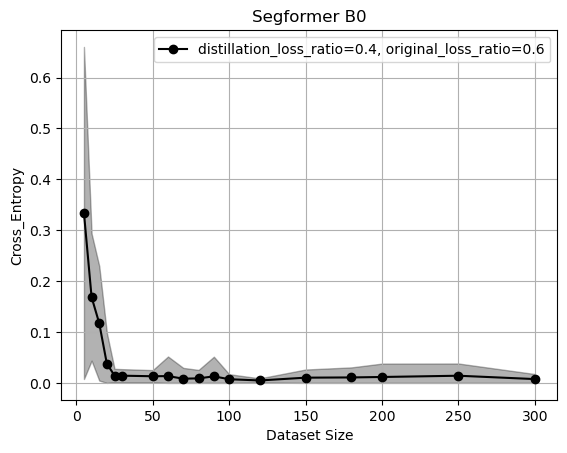

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0520')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.png"))

plt.show()